<center><div style="direction:rtl;font-family:B Lotus, B Nazanin, Tahoma">به نام خدا</div></center>
<img src= alt="class.vision" style="width: 200px;"/>
<h1><center><div style="direction:rtl;font-family:B Lotus, B Nazanin, Tahoma">Image captioning با Attention</div></center></h1>

Given an image like the example below, our goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [ ]:

import pickle
from PIL import Image
from glob import glob
import json
import time
import random
import numpy as np
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
      
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth harus diatur saat startup
        print(e)


def set_random_seeds(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Random seeds global diset ke: {seed}")


def set_model_to_eval_mode(encoder_model, decoder_model):
    """Set model ke mode evaluasi (trainable=False)."""
    encoder_model.trainable = False
    decoder_model.trainable = False


    # print("Model diset ke mode evaluasi (trainable=False)") # Opsional
set_random_seeds(42)  # Panggil sekali di awal

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning

# Scikit-learn includes many helpful utilities

2025-06-23 07:15:58.052781: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-23 07:15:58.068978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750662958.086573 2060504 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750662958.091791 2060504 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750662958.105339 2060504 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0
2 Physical GPUs, 2 Logical GPUs
Random seeds global diset ke: 42


I0000 00:00:1750662959.617650 2060504 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4440 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:31:00.0, compute capability: 8.6
I0000 00:00:1750662959.618007 2060504 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22291 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:4b:00.0, compute capability: 8.6


## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train our model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [2]:
annotation_zip = tf.keras.utils.get_file('captions.zip',
                                         cache_subdir=os.path.abspath('.'),
                                         origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                         extract=True)
annotation_file = os.path.dirname(
    annotation_zip)+'/captions_extracted/annotations/captions_train2014.json'

name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
    image_zip = tf.keras.utils.get_file(name_of_zip,
                                        cache_subdir=os.path.abspath('.'),
                                        origin='http://images.cocodataset.org/zips/train2014.zip',
                                        extract=True)
    PATH = os.path.dirname(image_zip)+'/train2014_extracted/train2014/'
else:
    PATH = os.path.abspath('.')+'/train2014_extracted/train2014/'

## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality.

In [3]:

with open(annotation_file, 'r') as f:
    annotations = json.load(f)

all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)


train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)


num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [4]:
from transformers import ViTImageProcessor, TFViTModel

VIT_MODEL_NAME = "google/vit-base-patch16-224"
IMG_SIZE = 224
PATCH_SIZE = 16

try:
    vit_processor = ViTImageProcessor.from_pretrained(VIT_MODEL_NAME)

    vit_image_processor = ViTImageProcessor.from_pretrained(VIT_MODEL_NAME)
    vit_model = TFViTModel.from_pretrained(VIT_MODEL_NAME)
    vit_model.trainable = False
    print("ViTImageProcessor berhasil dimuat.")
    print(
        f"ViT Processor dan Model ('{VIT_MODEL_NAME}') berhasil dimuat dan dibekukan.")
except ModuleNotFoundError as e_mod:
    print(f"Error modul setelah restart: {e_mod}")
    print("Jika masih error, mungkin ada masalah environment yang lebih dalam.")
except Exception as e:
    print(f"Gagal memuat komponen ViT setelah restart: {e}.")

/home/c14210092/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pool

ViTImageProcessor berhasil dimuat.
ViT Processor dan Model ('google/vit-base-patch16-224') berhasil dimuat dan dibekukan.


In [5]:
def load_and_preprocess_image_for_vit(image_path_str):
    try:
        img = Image.open(image_path_str).convert("RGB")
        processed_inputs = vit_image_processor(images=img, return_tensors="tf")
        img_tensor = processed_inputs['pixel_values']
        return img_tensor, image_path_str
    except Exception as e:
        print(f"Error loading/processing image {image_path_str}: {e}")
        return None, image_path_str


NUM_PATCHES = (IMG_SIZE // PATCH_SIZE)**2
VIT_FEATURE_DIM = vit_model.config.hidden_size
print(
    f"ViT Config: Num Patches (setelah CLS token dihilangkan nanti) = {NUM_PATCHES}, Hidden Size = {VIT_FEATURE_DIM}")

ViT Config: Num Patches (setelah CLS token dihilangkan nanti) = 196, Hidden Size = 768


In [6]:

import gc
BASE_DIR = os.path.abspath('.')
VIT_FEATURES_DIR = os.path.join(
    BASE_DIR, 'features_vit_transformer_model')  # Nama dir baru
if not os.path.exists(VIT_FEATURES_DIR):
    os.makedirs(VIT_FEATURES_DIR)
    print(f"Direktori '{VIT_FEATURES_DIR}' dibuat.")

encode_train_paths = sorted(list(set(img_name_vector)))
print(f"Jumlah gambar unik untuk ekstraksi fitur: {len(encode_train_paths)}")

all_features_exist = True
if not encode_train_paths:
    all_features_exist = True
else:
    for img_path in encode_train_paths:
        path_of_feature = os.path.join(
            VIT_FEATURES_DIR, os.path.basename(img_path) + '.npy')
        if not os.path.exists(path_of_feature):
            all_features_exist = False
            break


if not all_features_exist:
    print(f"Memulai caching fitur ViT ke '{VIT_FEATURES_DIR}'...")
    image_dataset_caching = tf.data.Dataset.from_tensor_slices(
        encode_train_paths)
    image_dataset_caching = image_dataset_caching.map(
        lambda x: tf.numpy_function(load_and_preprocess_image_for_vit, [
                                    x], [tf.float32, tf.string]),
        num_parallel_calls=1
    ).batch(1)

    processed_count_cache = 0
    total_to_cache = len(encode_train_paths)
    start_time_cache = time.time()
    if total_to_cache > 0:
        for batch_idx_cache, (img_batch_cache, path_batch_cache) in enumerate(image_dataset_caching):
            current_path_str_cache = path_batch_cache.numpy()[
                0].decode('utf-8')
            if (batch_idx_cache + 1) % 100 == 0 or (batch_idx_cache + 1) == 1 or (batch_idx_cache + 1) == total_to_cache:
                print(
                    f"  Caching: {batch_idx_cache + 1}/{total_to_cache} - {current_path_str_cache.split('/')[-1]}")

            if img_batch_cache is None or img_batch_cache.shape[0] == 0:
                continue
            img_input_vit_cache = tf.squeeze(img_batch_cache, axis=1) if len(
                img_batch_cache.shape) == 5 else img_batch_cache
            if len(img_input_vit_cache.shape) != 4:
                continue

            try:
                vit_output_cache = vit_model(
                    img_input_vit_cache, training=False)
                # (1, NUM_PATCHES, VIT_FEATURE_DIM)
                patch_features_cache = vit_output_cache.last_hidden_state[:, 1:, :]
                feature_to_save_cache = patch_features_cache[0].numpy()
                save_path_cache = os.path.join(
                    VIT_FEATURES_DIR, os.path.basename(current_path_str_cache) + '.npy')
                np.save(save_path_cache, feature_to_save_cache)
                processed_count_cache += 1
            except Exception as e_c:
                print(f"    Error caching {current_path_str_cache}: {e_c}")
            if (batch_idx_cache + 1) % 200 == 0:
                gc.collect()
        print(
            f"Caching ViT selesai. {processed_count_cache}/{total_to_cache} fitur disimpan. Waktu: {(time.time()-start_time_cache)/60:.2f} m")
    else:
        print("Tidak ada gambar untuk di-cache.")
else:
    print(f"Semua fitur ViT sudah ada di '{VIT_FEATURES_DIR}'.")

Jumlah gambar unik untuk ekstraksi fitur: 25950
Semua fitur ViT sudah ada di '/home/c14210092/vit/features_vit_transformer_model'.


In [7]:

top_k_tokenizer = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=top_k_tokenizer, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_sequences = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
caption_vectors = tf.keras.preprocessing.sequence.pad_sequences(
    train_sequences, padding='post')
max_caption_length = caption_vectors.shape[1]
vocab_size_effective = len(tokenizer.word_index) + 1
print(f"Max caption length: {max_caption_length}")
print(f"Effective vocabulary size: {vocab_size_effective}")

<>:3: SyntaxWarning: invalid escape sequence '\]'
<>:3: SyntaxWarning: invalid escape sequence '\]'
/tmp/ipykernel_2060504/910641793.py:3: SyntaxWarning: invalid escape sequence '\]'
  num_words=top_k_tokenizer, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')


Max caption length: 49
Effective vocabulary size: 8236


In [8]:
img_names_train_split, img_names_val_split, caps_train_split, caps_val_split = train_test_split(
    img_name_vector, caption_vectors, test_size=0.2, random_state=0
)
print(
    f"Training set: {len(img_names_train_split)} images, Validation set: {len(img_names_val_split)} images")

Training set: 24000 images, Validation set: 6000 images


In [ ]:
D_MODEL_TRANSFORMER = 256
NUM_DECODER_LAYERS_TRANSFORMER = 4
NUM_HEADS_TRANSFORMER = 8
DFF_FEED_FORWARD_TRANSFORMER = 512
DROPOUT_RATE_TRANSFORMER = 0.1
BATCH_SIZE_FOR_TRAINING = 64
BUFFER_SIZE_SHUFFLE = 1000


GRID_SIZE_ATTENTION_PLOT = int(np.sqrt(NUM_PATCHES))
if GRID_SIZE_ATTENTION_PLOT**2 != NUM_PATCHES:
    print(
        f"Peringatan: NUM_PATCHES ({NUM_PATCHES}) bukan kuadrat sempurna. Plotting attention mungkin kurang akurat.")


def load_cached_vit_features_map_func(img_name_tensor_bytes, cap_numpy_array):
    img_name_str = img_name_tensor_bytes.decode('utf-8')

    feature_path = os.path.join(
        VIT_FEATURES_DIR, os.path.basename(img_name_str) + '.npy')
    try:
        vit_feature_sequence = np.load(feature_path)

        return vit_feature_sequence.astype(np.float32), cap_numpy_array.astype(np.int32)
    except FileNotFoundError:
        print(
            f"File fitur tidak ditemukan: {feature_path}. Mengembalikan zeros.")
    
        return np.zeros((NUM_PATCHES, VIT_FEATURE_DIM), dtype=np.float32), cap_numpy_array.astype(np.int32)
    except Exception as e:
        print(
            f"Error saat memuat fitur {feature_path}: {e}. Mengembalikan zeros.")
        return np.zeros((NUM_PATCHES, VIT_FEATURE_DIM), dtype=np.float32), cap_numpy_array.astype(np.int32)


dataset_train_transformer = tf.data.Dataset.from_tensor_slices(
    (img_names_train_split, caps_train_split))
dataset_train_transformer = dataset_train_transformer.map(lambda item1, item2: tf.numpy_function(
    load_cached_vit_features_map_func,
    [item1, item2],
    [tf.float32, tf.int32]
), num_parallel_calls=tf.data.experimental.AUTOTUNE)


def set_shapes(features, captions):
    features.set_shape([NUM_PATCHES, VIT_FEATURE_DIM])
    captions.set_shape([max_caption_length])
    return features, captions


dataset_train_transformer = dataset_train_transformer.map(set_shapes)

dataset_train_transformer = dataset_train_transformer.shuffle(
    BUFFER_SIZE_SHUFFLE)

dataset_train_transformer = dataset_train_transformer.batch(
    BATCH_SIZE_FOR_TRAINING, drop_remainder=True)
dataset_train_transformer = dataset_train_transformer.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[
                            np.newaxis, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding_val = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding_val, dtype=tf.float32)


def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(
        seq, tokenizer.word_index['<pad>']), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]


def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask


class MultiHeadAttentionTF(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttentionTF, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        output = self.dense(output)
        return output, attention_weights

    def get_config(self):
        config = super(MultiHeadAttentionTF, self).get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
         
        })
        return config

    @classmethod
    def from_config(cls, config):
 
        return cls(**config)


def point_wise_feed_forward(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])


class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super(DecoderLayer, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate

        self.mha1 = MultiHeadAttentionTF(d_model, num_heads)
        self.mha2 = MultiHeadAttentionTF(d_model, num_heads)
        self.ffn = point_wise_feed_forward(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask_enc):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask_enc)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        return out3, attn_weights_block1, attn_weights_block2

    def get_config(self):
        config = super(DecoderLayer, self).get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "dff": self.dff,
            "rate": self.rate,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)




class TransformerCaptionDecoder(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 target_vocab_size, max_seq_len_pos_encoding, rate=0.1, **kwargs):

        if 'dtype' in kwargs and isinstance(kwargs['dtype'], dict):
            kwargs.pop('dtype')
        super(TransformerCaptionDecoder, self).__init__(**kwargs)
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.target_vocab_size = target_vocab_size
        self.max_seq_len_pos_encoding = max_seq_len_pos_encoding
        self.rate = rate

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(  # Ini adalah TENSOR
            max_seq_len_pos_encoding, d_model)

        self.decoder_layers = [
            DecoderLayer(d_model, num_heads, dff, rate,
                         name=f"decoder_layer_{i}")  # Memberi nama layer adalah praktik yang baik
            for i in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(rate)
        self.final_dense_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, target_caption_tokens, adapted_vit_encoder_output, training=False):
        seq_len = tf.shape(target_caption_tokens)[1]

        look_ahead_m = create_look_ahead_mask(seq_len)

        dec_target_padding_m = create_padding_mask(target_caption_tokens)
        combined_m = tf.maximum(dec_target_padding_m, look_ahead_m)

        enc_padding_m = None  
        x = self.embedding(target_caption_tokens)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))


        x += self.pos_encoding[:, :seq_len, :]


        x = self.dropout(x, training=training)

        attention_weights_all_layers = {}
      
        for i, decoder_layer_obj in enumerate(self.decoder_layers):
            x, block1_att, block2_att = decoder_layer_obj(  
                x,
                adapted_vit_encoder_output,
                training=training,
                look_ahead_mask=combined_m,
                padding_mask_enc=enc_padding_m
            )
            attention_weights_all_layers[f'decoder_layer{i+1}_self_att'] = block1_att
            attention_weights_all_layers[f'decoder_layer{i+1}_cross_att_img'] = block2_att

        predictions = self.final_dense_layer(x)
        return predictions, attention_weights_all_layers

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_layers": self.num_layers,
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "dff": self.dff,
            "target_vocab_size": self.target_vocab_size,
            "max_seq_len_pos_encoding": self.max_seq_len_pos_encoding,
            "rate": self.rate,
        })
        return config

    @classmethod
    def from_config(cls, config):
        if 'dtype' in config and isinstance(config['dtype'], dict):
            config.pop('dtype')
        return cls(**config)


class ViTFeaturesProjection(tf.keras.Model):
    def __init__(self, target_d_model_for_transformer, **kwargs):
        if 'dtype' in kwargs and isinstance(kwargs['dtype'], dict):
            # Hapus dtype jika berupa dict (serialized DTypePolicy)
            kwargs.pop('dtype')
        super(ViTFeaturesProjection, self).__init__(**kwargs)
        self.target_d_model_for_transformer = target_d_model_for_transformer
        self.projection_layer = tf.keras.layers.Dense(
            target_d_model_for_transformer, activation='relu')

    def call(self, raw_vit_patch_features, training=False):
        return self.projection_layer(raw_vit_patch_features)

    def get_config(self):
        config = super().get_config()
        config.update({
            "target_d_model_for_transformer": self.target_d_model_for_transformer
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Tangani dtype di config
        if 'dtype' in config and isinstance(config['dtype'], dict):
            config.pop('dtype')
        return cls(**config)


vit_feature_projector = ViTFeaturesProjection(D_MODEL_TRANSFORMER)
caption_transformer_decoder = TransformerCaptionDecoder(
    num_layers=NUM_DECODER_LAYERS_TRANSFORMER,
    d_model=D_MODEL_TRANSFORMER,
    num_heads=NUM_HEADS_TRANSFORMER,
    dff=DFF_FEED_FORWARD_TRANSFORMER,
    target_vocab_size=vocab_size_effective,
    max_seq_len_pos_encoding=max_caption_length,
    rate=DROPOUT_RATE_TRANSFORMER
)


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = float(warmup_steps)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)

        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


learning_rate_schedule = CustomSchedule(D_MODEL_TRANSFORMER)
optimizer_tr = tf.keras.optimizers.Adam(
    learning_rate_schedule,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)

loss_object_tr = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def masked_loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(
        real, tokenizer.word_index['<pad>']))
    loss_ = loss_object_tr(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


checkpoint_dir_tr = './checkpoints_full_transformer_v2'
ckpt_tr = tf.train.Checkpoint(vit_feature_projector=vit_feature_projector,
                              caption_transformer_decoder=caption_transformer_decoder,
                              optimizer=optimizer_tr)
ckpt_manager_tr = tf.train.CheckpointManager(
    ckpt_tr, checkpoint_dir_tr, max_to_keep=5)
start_epoch_tr = 0
if ckpt_manager_tr.latest_checkpoint:
    ckpt_tr.restore(ckpt_manager_tr.latest_checkpoint)
    start_epoch_tr = int(ckpt_manager_tr.latest_checkpoint.split('-')[-1])
    print(
        f"Checkpoint Transformer '{ckpt_manager_tr.latest_checkpoint}' restored, starting from epoch {start_epoch_tr+1}")


@tf.function
def train_step_transformer_model(cached_vit_features, target_caption_seq):
    tar_input = target_caption_seq[:, :-1]
    tar_real_output = target_caption_seq[:, 1:]

    with tf.GradientTape() as tape:
        projected_vit_features = vit_feature_projector(
            cached_vit_features, training=True)
      
        predictions, _ = caption_transformer_decoder(
            tar_input, projected_vit_features, training=True)
        loss = masked_loss_function(tar_real_output, predictions)

    trainable_vars_tr = vit_feature_projector.trainable_variables + \
        caption_transformer_decoder.trainable_variables
    gradients_tr = tape.gradient(loss, trainable_vars_tr)
    optimizer_tr.apply_gradients(zip(gradients_tr, trainable_vars_tr))
    return loss

In [ ]:

EPOCHS_TRANSFORMER = 20
BATCH_SIZE_FOR_TRAINING = 64
train_loss_history_tr = []
num_steps_per_epoch_tr = len(img_names_train_split) // BATCH_SIZE_FOR_TRAINING
if len(img_names_train_split) % BATCH_SIZE_FOR_TRAINING != 0:
    num_steps_per_epoch_tr += 1

print(
    f"\nMemulai Training Model Full Transformer dari epoch {start_epoch_tr + 1}...")
for epoch_tr in range(start_epoch_tr, EPOCHS_TRANSFORMER):
    epoch_start_time_tr = time.time()
    total_epoch_loss_val_tr = 0.0

    for (batch_num_tr, (vit_feat_batch, target_cap_batch)) in enumerate(dataset_train_transformer):
        batch_loss_tr = train_step_transformer_model(
            vit_feat_batch, target_cap_batch)
        total_epoch_loss_val_tr += batch_loss_tr

        if batch_num_tr % 50 == 0:
            print(
                f'  Epoch {epoch_tr + 1} Batch {batch_num_tr}/{num_steps_per_epoch_tr} Loss: {batch_loss_tr.numpy():.4f}')

    avg_epoch_loss_val_tr = total_epoch_loss_val_tr / num_steps_per_epoch_tr
    train_loss_history_tr.append(avg_epoch_loss_val_tr.numpy())

    if (epoch_tr + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager_tr.save()
        print(
            f'  Checkpoint disimpan untuk epoch {epoch_tr+1} di {ckpt_save_path}')

    print(f'Epoch {epoch_tr + 1} Avg. Loss: {avg_epoch_loss_val_tr.numpy():.4f}, Time: {time.time() - epoch_start_time_tr:.2f} sec\n')


def evaluate_caption_transformer(image_path_str_eval):
    max_gen_len = max_caption_length
    img_tensor_eval, _ = load_and_preprocess_image_for_vit(image_path_str_eval)
    if img_tensor_eval is None:
        return ["<error image load>"], np.array([])

    img_input_vit_eval = tf.squeeze(img_tensor_eval, axis=1) if len(
        img_tensor_eval.shape) == 5 else img_tensor_eval
    if len(img_input_vit_eval.shape) != 4:
        return ["<error image shape eval>"], np.array([])

    vit_output_eval = vit_model(img_input_vit_eval, training=False)
    raw_vit_patches_eval = vit_output_eval.last_hidden_state[:, 1:, :]
    projected_vit_features_eval = vit_feature_projector(
        raw_vit_patches_eval, training=False)

    start_token = tokenizer.word_index['<start>']
    end_token = tokenizer.word_index['<end>']

    decoder_output_sequence = tf.expand_dims([start_token], 0)  # (1, 1)
    generated_caption_words = []
    attention_weights_list_eval = []

    for i in range(max_gen_len):
        predictions_step, attention_step = caption_transformer_decoder(
            decoder_output_sequence, projected_vit_features_eval, training=False
        )

        cross_att_last_layer = attention_step[
            f'decoder_layer{NUM_DECODER_LAYERS_TRANSFORMER}_cross_att_img']
        current_token_cross_att = cross_att_last_layer[0, :, -1, :]
        avg_head_cross_att = tf.reduce_mean(current_token_cross_att, axis=0)
        attention_weights_list_eval.append(avg_head_cross_att.numpy())

        last_token_predictions = predictions_step[:, -1:, :]
        predicted_id_step = tf.cast(
            tf.argmax(last_token_predictions, axis=-1), tf.int32)
        if predicted_id_step[0][0] == end_token:
            break

        decoder_output_sequence = tf.concat(
            [decoder_output_sequence, predicted_id_step], axis=-1)
        generated_caption_words.append(tokenizer.index_word.get(
            predicted_id_step.numpy()[0][0], "<unk>"))

    final_attention_array = np.array(
        attention_weights_list_eval) if attention_weights_list_eval else np.zeros((0, NUM_PATCHES))
    return generated_caption_words, final_attention_array


def plot_attention_transformer_model(image_path_str_plot, generated_words_plot, attention_array_plot):
    if not os.path.exists(image_path_str_plot):
        print(f"Gambar tidak ditemukan untuk plotting: {image_path_str_plot}")
        return
    try:
        image_plot = np.array(Image.open(image_path_str_plot))
    except Exception as e_plot:
        print(
            f"Error membuka gambar {image_path_str_plot} untuk plot: {e_plot}")
        return

 
    fig_plot = plt.figure(
        figsize=(15, 15 + 2 * (len(generated_words_plot) // 4)))
    num_words_plot = len(generated_words_plot)

    if attention_array_plot.ndim == 0 or attention_array_plot.shape[0] == 0 or num_words_plot == 0:
        print("Tidak ada data attention yang valid atau kata yang digenerate untuk diplot.")
        ax_no_att = fig_plot.add_subplot(1, 1, 1)
        ax_no_att.imshow(image_plot)
        ax_no_att.set_title(' '.join(generated_words_plot)
                            if generated_words_plot else "Tidak ada caption", fontsize=12)
        ax_no_att.axis('off')
        plt.show()
        return

    cols_plot = min(num_words_plot, 4)
    rows_plot = (num_words_plot + cols_plot - 1) // cols_plot

    for i_plot in range(num_words_plot):
        if i_plot >= attention_array_plot.shape[0]:
            print(
                f"  Peringatan: Jumlah kata ({num_words_plot}) > jumlah attention map ({attention_array_plot.shape[0]}).")
            break

        ax_plot = fig_plot.add_subplot(rows_plot, cols_plot, i_plot + 1)
        ax_plot.set_title(generated_words_plot[i_plot], fontsize=10)
        img_disp_plot = ax_plot.imshow(image_plot)

        if GRID_SIZE_ATTENTION_PLOT**2 == NUM_PATCHES:
            attention_reshaped = np.resize(
                attention_array_plot[i_plot], (GRID_SIZE_ATTENTION_PLOT, GRID_SIZE_ATTENTION_PLOT))
            ax_plot.imshow(attention_reshaped, cmap='gray',
                           alpha=0.6, extent=img_disp_plot.get_extent())
        else:

            pass
        ax_plot.axis('off')

    plt.tight_layout(pad=0.5)
    plt.show()


Memulai Training Model Full Transformer dari epoch 1...
  Epoch 1 Batch 0/375 Loss: 9.0407
  Epoch 1 Batch 50/375 Loss: 8.7415
  Epoch 1 Batch 100/375 Loss: 8.2483
  Epoch 1 Batch 150/375 Loss: 7.7059
  Epoch 1 Batch 200/375 Loss: 7.0248
  Epoch 1 Batch 250/375 Loss: 6.3186
  Epoch 1 Batch 300/375 Loss: 5.7355
  Epoch 1 Batch 350/375 Loss: 5.2927


2025-06-23 07:17:09.304939: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 Avg. Loss: 7.1386, Time: 30.17 sec

  Epoch 2 Batch 0/375 Loss: 5.1887
  Epoch 2 Batch 50/375 Loss: 5.1249
  Epoch 2 Batch 100/375 Loss: 4.8962
  Epoch 2 Batch 150/375 Loss: 4.6730
  Epoch 2 Batch 200/375 Loss: 4.4796
  Epoch 2 Batch 250/375 Loss: 4.1248
  Epoch 2 Batch 300/375 Loss: 4.2028
  Epoch 2 Batch 350/375 Loss: 3.8024


2025-06-23 07:17:24.985568: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 Avg. Loss: 4.5204, Time: 15.68 sec

  Epoch 3 Batch 0/375 Loss: 4.0291
  Epoch 3 Batch 50/375 Loss: 3.7749
  Epoch 3 Batch 100/375 Loss: 4.1318
  Epoch 3 Batch 150/375 Loss: 3.7865
  Epoch 3 Batch 200/375 Loss: 3.6423
  Epoch 3 Batch 250/375 Loss: 3.6388
  Epoch 3 Batch 300/375 Loss: 3.4346
  Epoch 3 Batch 350/375 Loss: 3.4426
Epoch 3 Avg. Loss: 3.6353, Time: 15.60 sec

  Epoch 4 Batch 0/375 Loss: 3.1069
  Epoch 4 Batch 50/375 Loss: 3.2505
  Epoch 4 Batch 100/375 Loss: 3.2388
  Epoch 4 Batch 150/375 Loss: 2.8400
  Epoch 4 Batch 200/375 Loss: 3.1759
  Epoch 4 Batch 250/375 Loss: 3.2715
  Epoch 4 Batch 300/375 Loss: 3.2747
  Epoch 4 Batch 350/375 Loss: 2.9000


2025-06-23 07:17:56.281788: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4 Avg. Loss: 3.1985, Time: 15.70 sec

  Epoch 5 Batch 0/375 Loss: 3.0070
  Epoch 5 Batch 50/375 Loss: 2.9782
  Epoch 5 Batch 100/375 Loss: 2.9313
  Epoch 5 Batch 150/375 Loss: 2.8129
  Epoch 5 Batch 200/375 Loss: 3.0338
  Epoch 5 Batch 250/375 Loss: 2.6182
  Epoch 5 Batch 300/375 Loss: 2.7831
  Epoch 5 Batch 350/375 Loss: 2.8236
  Checkpoint disimpan untuk epoch 5 di ./checkpoints_full_transformer_v2/ckpt-1
Epoch 5 Avg. Loss: 2.9240, Time: 16.26 sec

  Epoch 6 Batch 0/375 Loss: 2.7901
  Epoch 6 Batch 50/375 Loss: 2.9238
  Epoch 6 Batch 100/375 Loss: 2.6497
  Epoch 6 Batch 150/375 Loss: 2.8084
  Epoch 6 Batch 200/375 Loss: 2.8065
  Epoch 6 Batch 250/375 Loss: 2.7777
  Epoch 6 Batch 300/375 Loss: 2.6366
  Epoch 6 Batch 350/375 Loss: 2.5035
Epoch 6 Avg. Loss: 2.7275, Time: 15.78 sec

  Epoch 7 Batch 0/375 Loss: 2.6558
  Epoch 7 Batch 50/375 Loss: 2.7229
  Epoch 7 Batch 100/375 Loss: 2.5066
  Epoch 7 Batch 150/375 Loss: 2.5491
  Epoch 7 Batch 200/375 Loss: 2.7089
  Epoch 7 Batch 250/

2025-06-23 07:18:59.887363: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8 Avg. Loss: 2.4311, Time: 15.89 sec

  Epoch 9 Batch 0/375 Loss: 2.2807
  Epoch 9 Batch 50/375 Loss: 2.1830
  Epoch 9 Batch 100/375 Loss: 2.5248
  Epoch 9 Batch 150/375 Loss: 2.3050
  Epoch 9 Batch 200/375 Loss: 2.2513
  Epoch 9 Batch 250/375 Loss: 2.2622
  Epoch 9 Batch 300/375 Loss: 2.1745
  Epoch 9 Batch 350/375 Loss: 2.3846
Epoch 9 Avg. Loss: 2.3045, Time: 16.00 sec

  Epoch 10 Batch 0/375 Loss: 2.0364
  Epoch 10 Batch 50/375 Loss: 2.1631
  Epoch 10 Batch 100/375 Loss: 2.5054
  Epoch 10 Batch 150/375 Loss: 2.1225
  Epoch 10 Batch 200/375 Loss: 1.9358
  Epoch 10 Batch 250/375 Loss: 2.1613
  Epoch 10 Batch 300/375 Loss: 2.0099
  Epoch 10 Batch 350/375 Loss: 2.0531
  Checkpoint disimpan untuk epoch 10 di ./checkpoints_full_transformer_v2/ckpt-2
Epoch 10 Avg. Loss: 2.1897, Time: 16.39 sec

  Epoch 11 Batch 0/375 Loss: 1.9045
  Epoch 11 Batch 50/375 Loss: 2.0430
  Epoch 11 Batch 100/375 Loss: 1.9365
  Epoch 11 Batch 150/375 Loss: 2.0879
  Epoch 11 Batch 200/375 Loss: 2.1478
  Epo

2025-06-23 07:21:07.210914: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16 Avg. Loss: 1.3561, Time: 15.72 sec

  Epoch 17 Batch 0/375 Loss: 1.3341
  Epoch 17 Batch 50/375 Loss: 1.2991
  Epoch 17 Batch 100/375 Loss: 1.2464
  Epoch 17 Batch 150/375 Loss: 1.2240
  Epoch 17 Batch 200/375 Loss: 1.1997
  Epoch 17 Batch 250/375 Loss: 1.1795
  Epoch 17 Batch 300/375 Loss: 1.3382
  Epoch 17 Batch 350/375 Loss: 1.1759
Epoch 17 Avg. Loss: 1.2397, Time: 15.88 sec

  Epoch 18 Batch 0/375 Loss: 1.2565
  Epoch 18 Batch 50/375 Loss: 1.2002
  Epoch 18 Batch 100/375 Loss: 1.1270
  Epoch 18 Batch 150/375 Loss: 1.1487
  Epoch 18 Batch 200/375 Loss: 1.0773
  Epoch 18 Batch 250/375 Loss: 1.1975
  Epoch 18 Batch 300/375 Loss: 1.1384
  Epoch 18 Batch 350/375 Loss: 1.0498
Epoch 18 Avg. Loss: 1.1388, Time: 15.86 sec

  Epoch 19 Batch 0/375 Loss: 1.0879
  Epoch 19 Batch 50/375 Loss: 1.0912
  Epoch 19 Batch 100/375 Loss: 1.1664
  Epoch 19 Batch 150/375 Loss: 1.1166
  Epoch 19 Batch 200/375 Loss: 1.1399
  Epoch 19 Batch 250/375 Loss: 1.2063
  Epoch 19 Batch 300/375 Loss: 1.0413


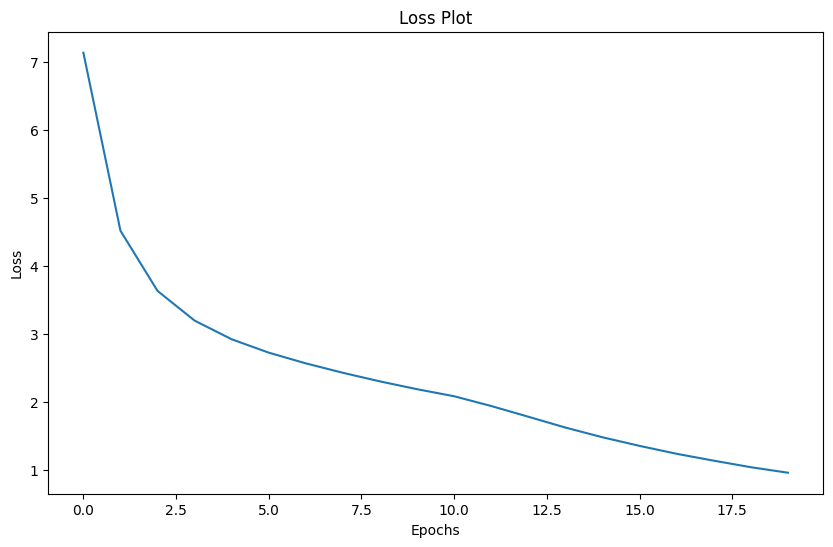

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.plot(train_loss_history_tr)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()


--- Evaluasi Akhir Model Full Transformer ---
Gambar: /home/c14210092/vit/train2014_extracted/train2014/COCO_train2014_000000185004.jpg
Real Caption    : people horseback riding on the beach and a dog and a man walking on the beach


I0000 00:00:1750663331.334828 2060504 cuda_dnn.cc:529] Loaded cuDNN version 90501


Predicted Caption: a group of people horses and a dog on a beach


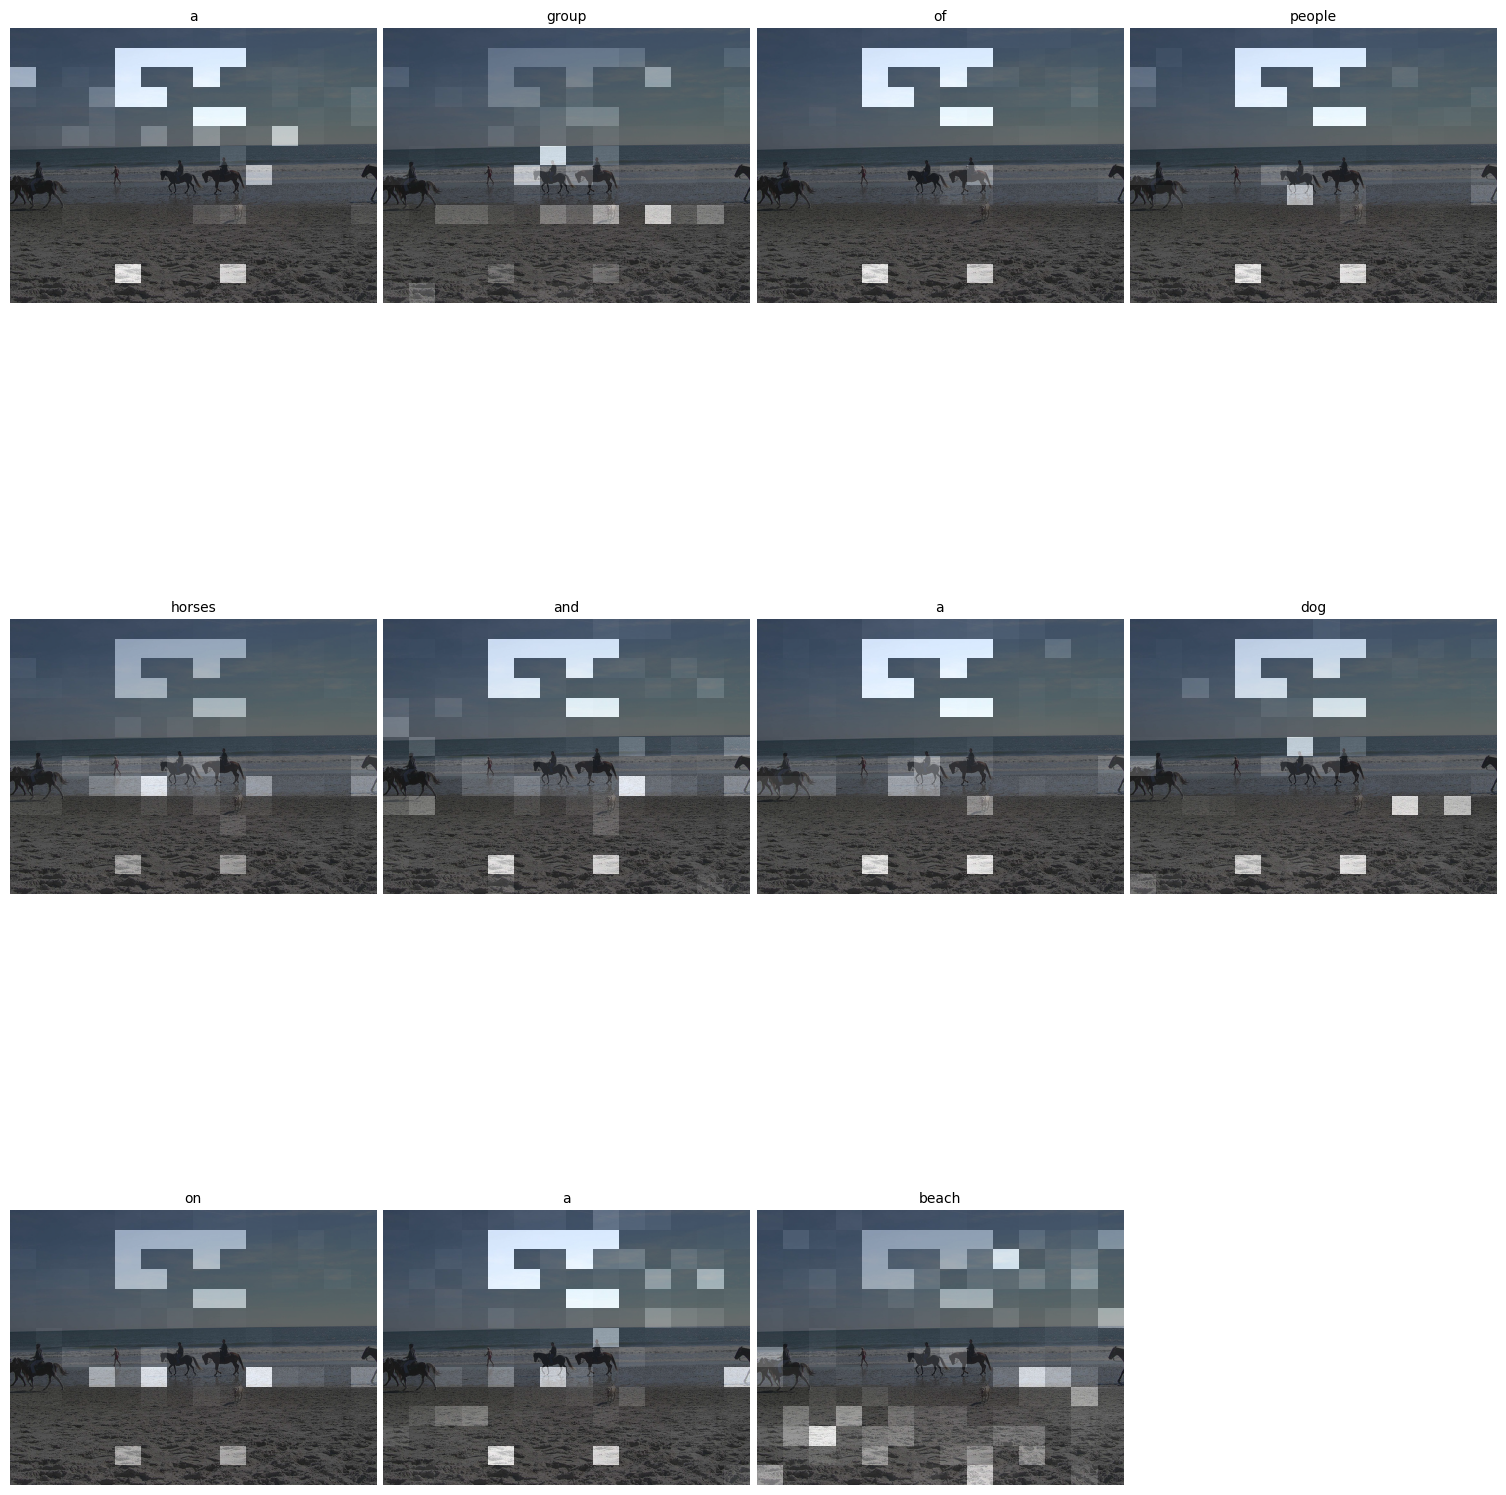

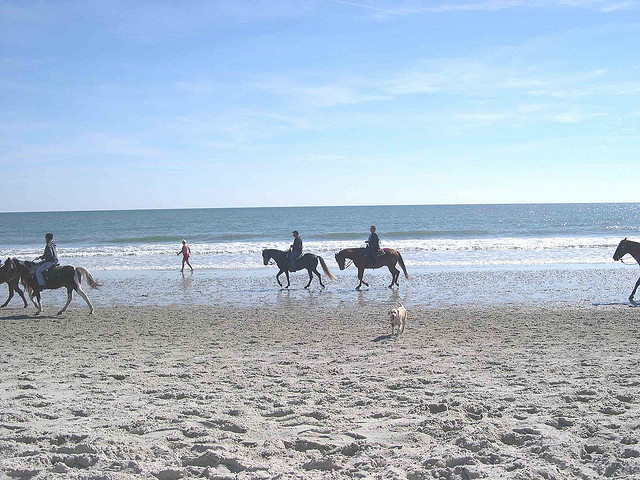


--- Evaluasi Gambar Kustom dengan Full Transformer ---
Gambar kustom diunduh ke: /home/c14210092/vit/my_test_image_transformer.jpg
Prediction (Custom): a man on a surf board riding a wave


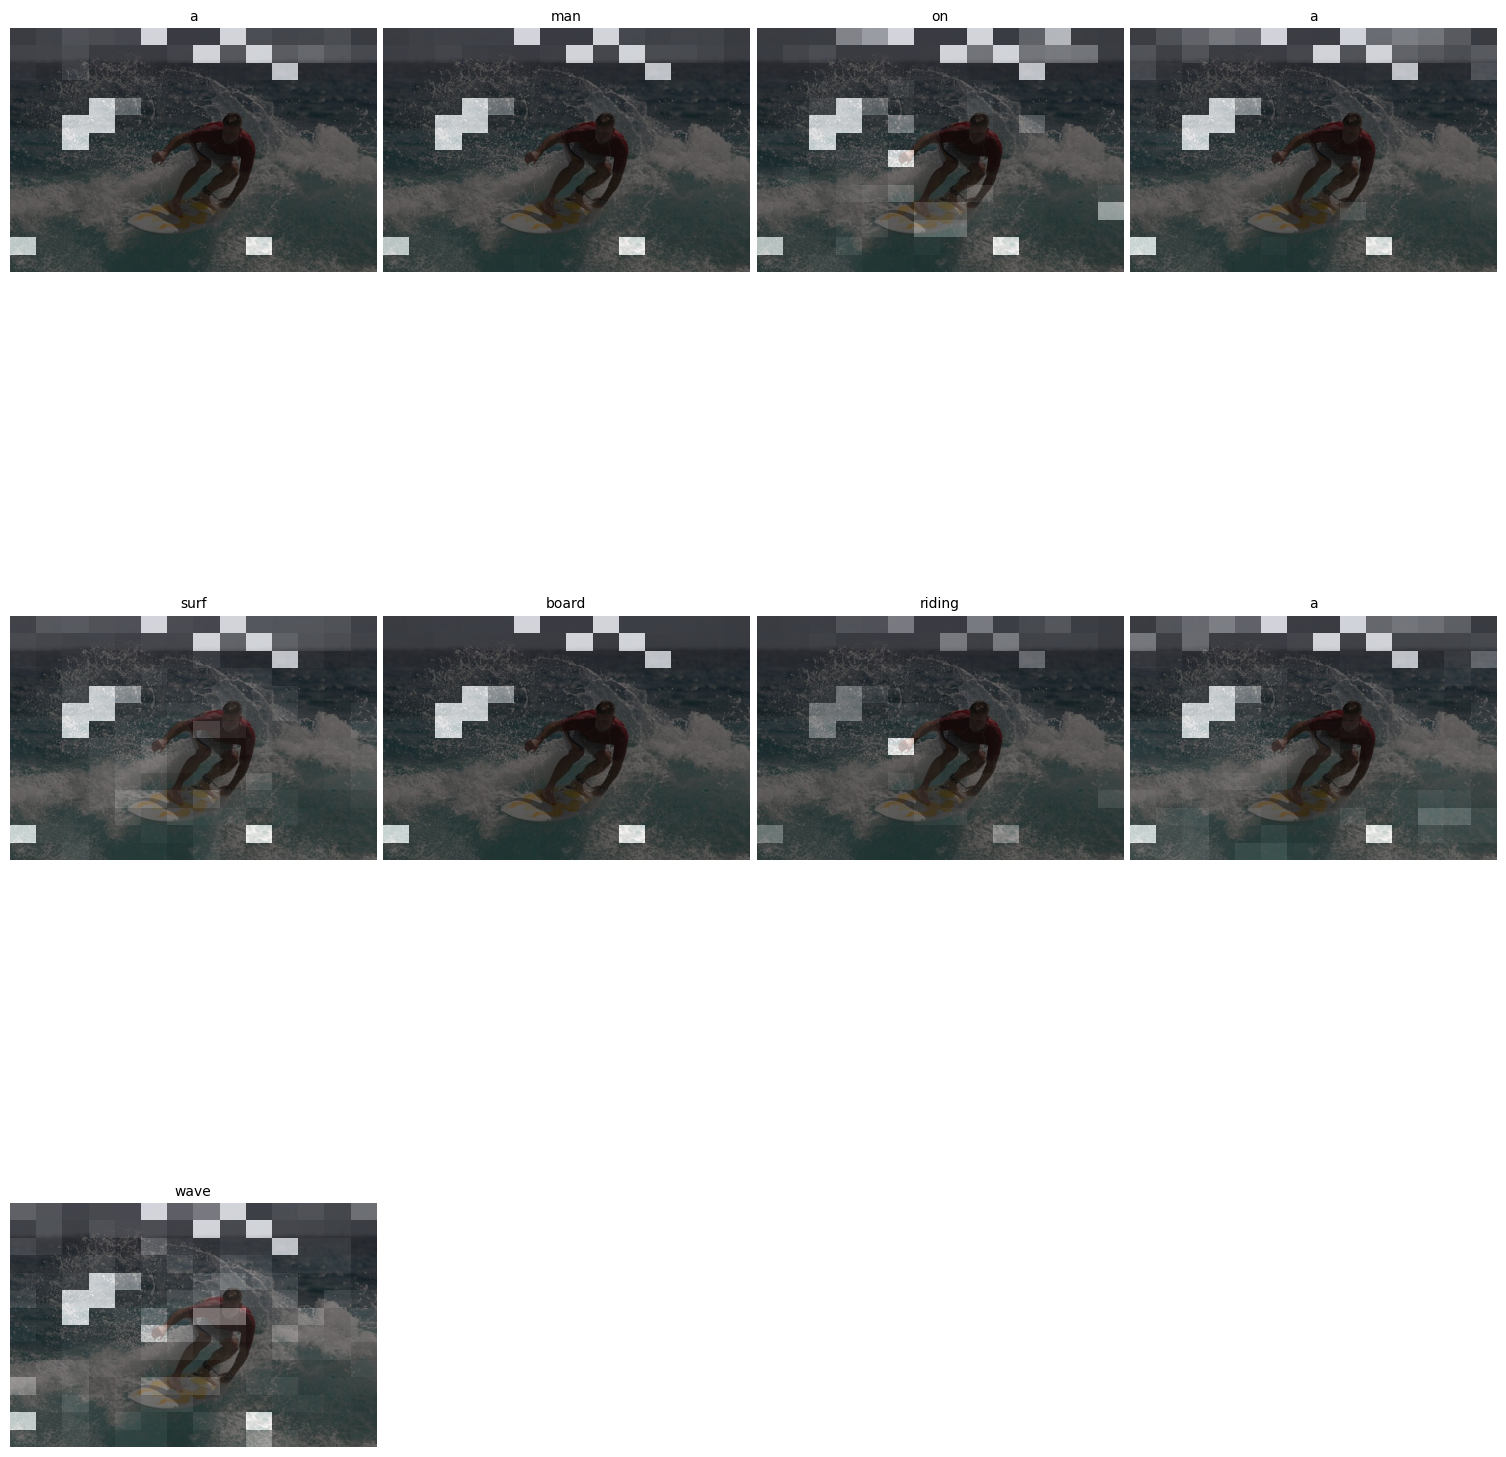

In [14]:

if 'img_names_val_split' in locals() and len(img_names_val_split) > 0:
    rid_eval = np.random.randint(0, len(img_names_val_split))
    eval_image_path = img_names_val_split[rid_eval]
    eval_real_caption_tokens = [tokenizer.index_word.get(
        tok_id, "") for tok_id in caps_val_split[rid_eval] if tok_id != tokenizer.word_index['<pad>']]
    eval_real_caption = ' '.join(eval_real_caption_tokens).replace(
        "<start>", "").replace("<end>", "").strip()

    print(f"\n--- Evaluasi Akhir Model Full Transformer ---")
    print(f"Gambar: {eval_image_path}")
    print(f"Real Caption    : {eval_real_caption}")

    eval_predicted_words, eval_attention_map = evaluate_caption_transformer(
        eval_image_path)
    eval_predicted_caption = ' '.join(eval_predicted_words)
    print(f"Predicted Caption: {eval_predicted_caption}")

    plot_attention_transformer_model(
        eval_image_path, eval_predicted_words, eval_attention_map)
    try:
        display(Image.open(eval_image_path))
    except NameError:
        Image.open(eval_image_path).show()

print(f"\n--- Evaluasi Gambar Kustom dengan Full Transformer ---")
custom_url = 'https://tensorflow.org/images/surf.jpg'
custom_ext = os.path.splitext(custom_url)[1] if os.path.splitext(custom_url)[
    1] else ".jpg"
try:
    my_custom_img_path = tf.keras.utils.get_file(
        'my_test_image_transformer'+custom_ext, origin=custom_url, cache_subdir=os.path.abspath('.'))
    print(f"Gambar kustom diunduh ke: {my_custom_img_path}")
    custom_pred_words, custom_att_map = evaluate_caption_transformer(
        my_custom_img_path)
    print(f"Prediction (Custom): {' '.join(custom_pred_words)}")
    plot_attention_transformer_model(
        my_custom_img_path, custom_pred_words, custom_att_map)
    Image.open(my_custom_img_path).show()
except Exception as e_cust:
    print(f"Gagal memproses gambar kustom: {e_cust}")


--- Evaluasi Gambar Kustom dengan Full Transformer ---
Gambar lokal ditemukan: /home/c14210092/vit/load.jpg


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmp1pmrrglu.PNG'


Prediction (Custom): a soccer ball in the park with a few different kinds of scissors


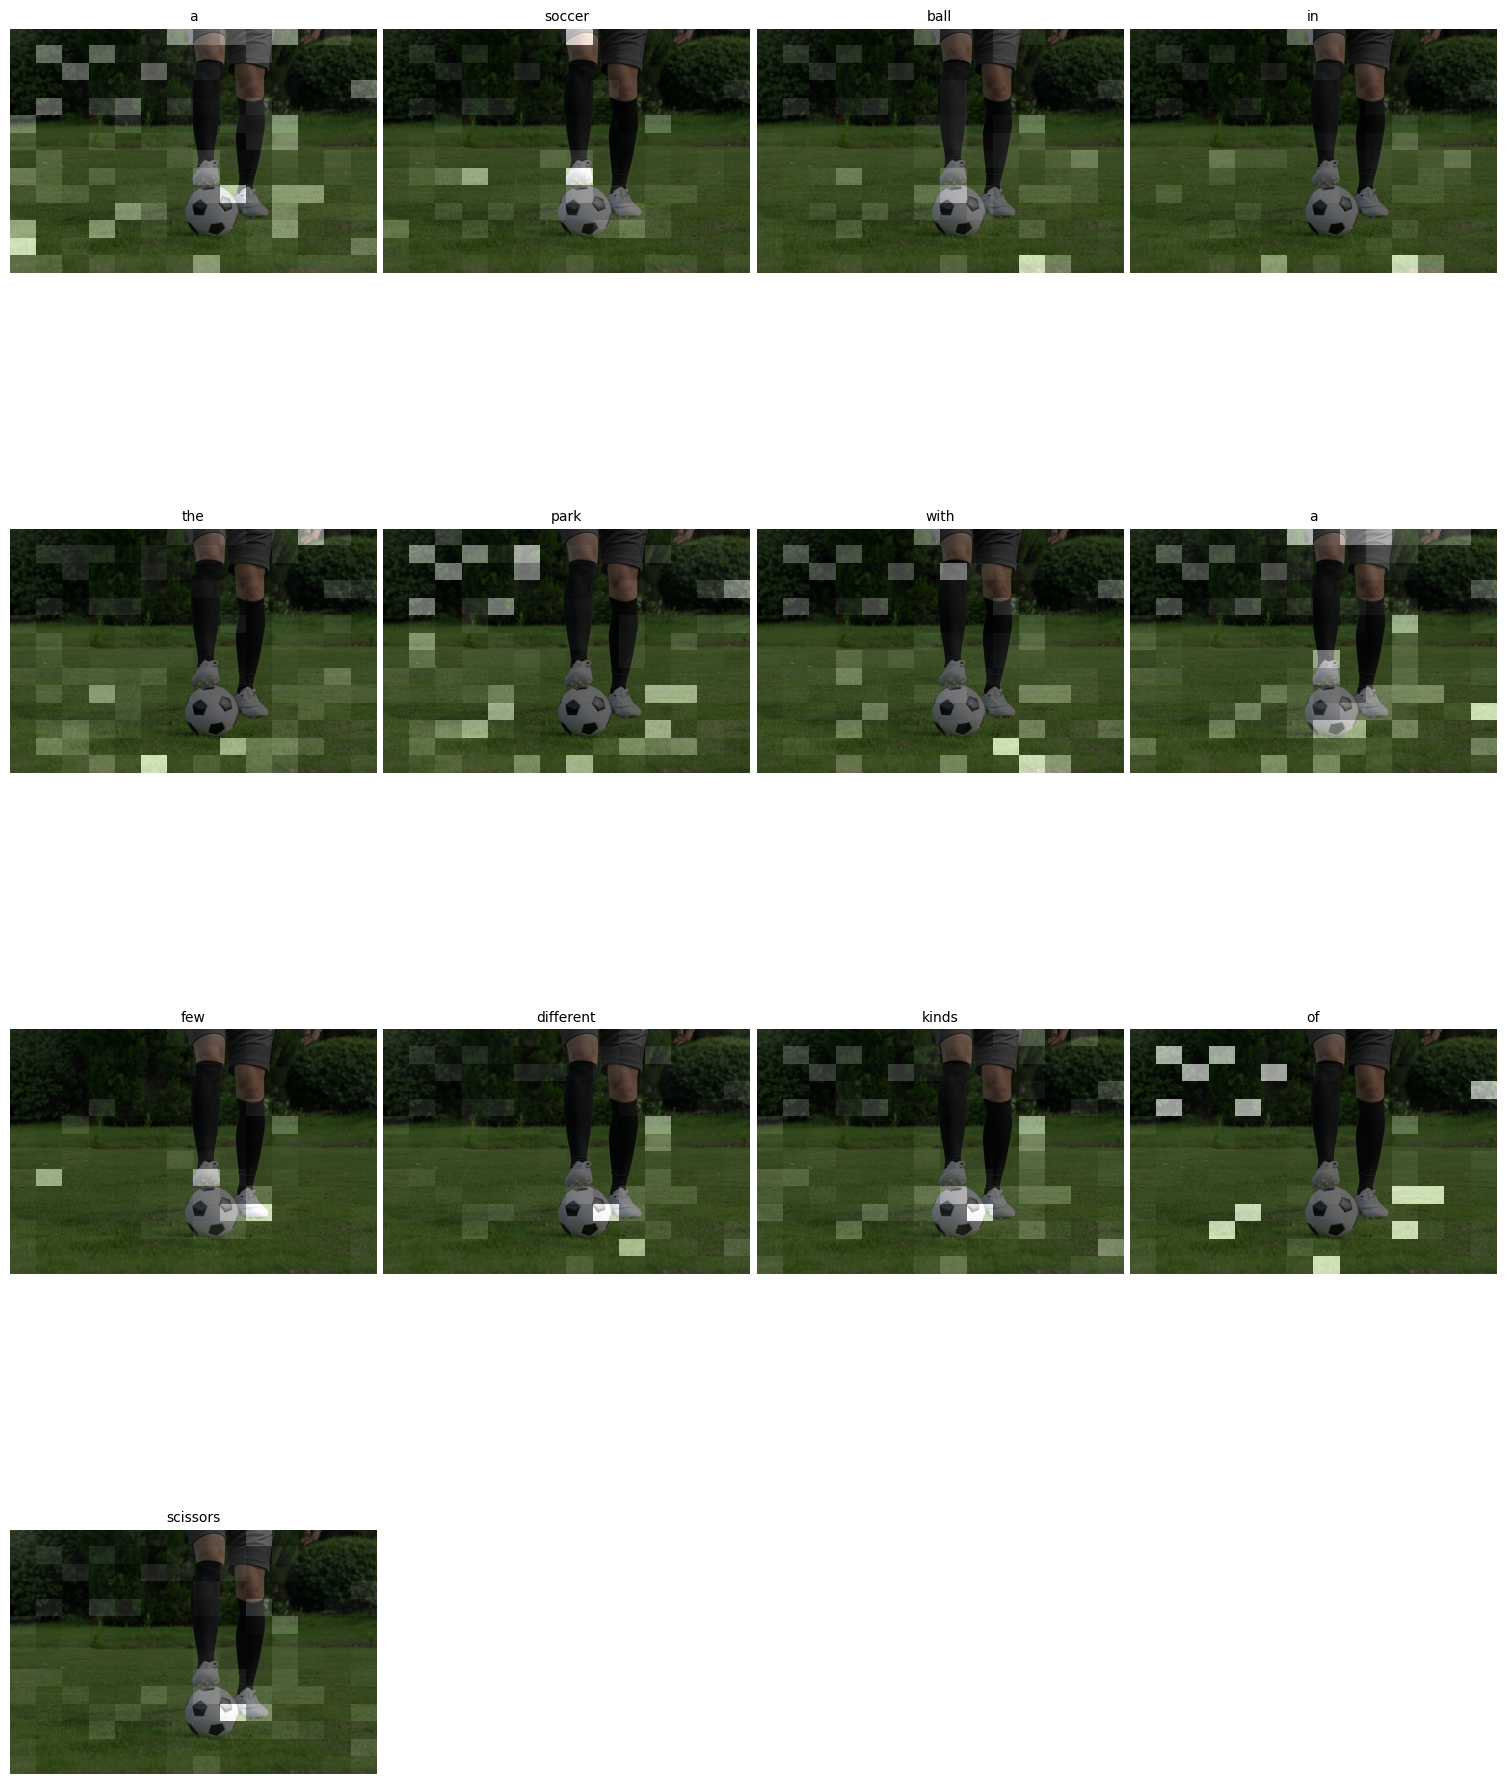

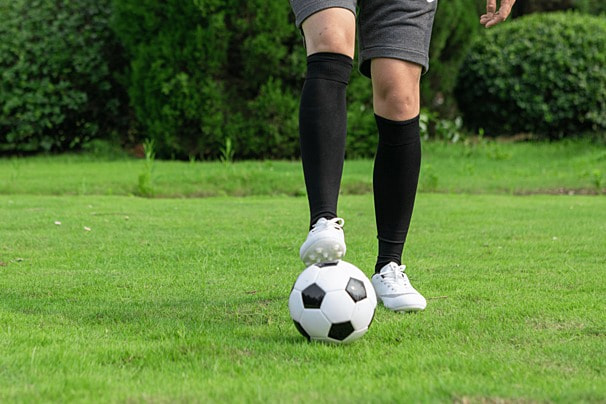

In [15]:
print(f"\n--- Evaluasi Gambar Kustom dengan Full Transformer ---")
custom_img_local_path = os.path.abspath(
    'load.jpg')  # Gambar lokal di direktori saat ini

if os.path.exists(custom_img_local_path):
    print(f"Gambar lokal ditemukan: {custom_img_local_path}")
    custom_pred_words, custom_att_map = evaluate_caption_transformer(
        custom_img_local_path)
    print(f"Prediction (Custom): {' '.join(custom_pred_words)}")
    plot_attention_transformer_model(
        custom_img_local_path, custom_pred_words, custom_att_map)
    try:
        display(Image.open(custom_img_local_path))
    except NameError:
        Image.open(custom_img_local_path).show()
else:
    print(
        f"Gambar load.jpg tidak ditemukan di direktori ini: {custom_img_local_path}")

In [16]:
import os
import pickle
import json
import tensorflow as tf


MODEL_SAVE_DIR_KERAS_FORMAT = os.path.join(
    os.path.abspath('.'), 'trained_caption_model_keras_tes')
if not os.path.exists(MODEL_SAVE_DIR_KERAS_FORMAT):
    os.makedirs(MODEL_SAVE_DIR_KERAS_FORMAT)
    print(f"Direktori '{MODEL_SAVE_DIR_KERAS_FORMAT}' dibuat.")
else:
    print(f"Direktori '{MODEL_SAVE_DIR_KERAS_FORMAT}' sudah ada.")

print(
    f"Aset model (.keras format) akan disimpan di: {MODEL_SAVE_DIR_KERAS_FORMAT}")


tokenizer_path = os.path.join(MODEL_SAVE_DIR_KERAS_FORMAT, 'tokenizer.pkl')
try:
    with open(tokenizer_path, 'wb') as f:
        pickle.dump(tokenizer, f)
    print(f"Tokenizer berhasil disimpan di: {tokenizer_path}")
except Exception as e:
    print(f"Gagal menyimpan tokenizer: {e}")


projector_keras_path = os.path.join(
    MODEL_SAVE_DIR_KERAS_FORMAT, 'vit_feature_projector.keras')
decoder_keras_path = os.path.join(
    MODEL_SAVE_DIR_KERAS_FORMAT, 'caption_transformer_decoder.keras')

print(f"\nMencoba menyimpan ViT Feature Projector ke: {projector_keras_path}")
try:

    if not vit_feature_projector.built:
        print("Membangun vit_feature_projector sebelum menyimpan...")
        if 'dataset_train_transformer' in locals() and dataset_train_transformer is not None:
            sample_vit_features_for_build, _ = next(
                iter(dataset_train_transformer.take(1)))
            _ = vit_feature_projector(
                sample_vit_features_for_build)
            print("vit_feature_projector dibangun.")
        else:
            vit_feature_projector.build(input_shape=(
                None, loaded_config['NUM_PATCHES'], loaded_config['VIT_FEATURE_DIM']))
            print("vit_feature_projector dibangun dengan shape dummy.")

    vit_feature_projector.save(projector_keras_path)
    print(
        f"ViT Feature Projector BERHASIL disimpan di: {projector_keras_path}")
except Exception as e:
    print(f"GAGAL menyimpan ViT Feature Projector sebagai .keras: {e}")
    import traceback
    traceback.print_exc()

print(
    f"\nMencoba menyimpan Transformer Caption Decoder ke: {decoder_keras_path}")
try:
    if not caption_transformer_decoder.built:
        print("Membangun caption_transformer_decoder sebelum menyimpan...")
        if 'dataset_train_transformer' in locals() and dataset_train_transformer is not None:
            sample_vit_features_for_build, sample_captions_for_build = next(
                iter(dataset_train_transformer.take(1)))
            if not vit_feature_projector.built:
                _ = vit_feature_projector(sample_vit_features_for_build)
            projected_features = vit_feature_projector(
                sample_vit_features_for_build)
            _ = caption_transformer_decoder(
                sample_captions_for_build[:, :-1], projected_features)
            print("caption_transformer_decoder dibangun.")
        else:  # Fallback
            _ = caption_transformer_decoder(
                tf.zeros(
                    (1, loaded_config['max_caption_length'] - 1), dtype=tf.int32),
                tf.zeros(
                    (1, loaded_config['NUM_PATCHES'], loaded_config['D_MODEL_TRANSFORMER']), dtype=tf.float32)
            )
            print("caption_transformer_decoder dibangun dengan input dummy.")

    caption_transformer_decoder.save(decoder_keras_path)
    print(
        f"Transformer Caption Decoder BERHASIL disimpan di: {decoder_keras_path}")
except Exception as e:
    print(f"GAGAL menyimpan Transformer Caption Decoder sebagai .keras: {e}")
    import traceback
    traceback.print_exc()

print("\nMenyimpan konfigurasi model...")
config_to_save = {
    "VIT_MODEL_NAME": VIT_MODEL_NAME, "IMG_SIZE": IMG_SIZE, "PATCH_SIZE": PATCH_SIZE,
    "NUM_PATCHES": NUM_PATCHES, "VIT_FEATURE_DIM": VIT_FEATURE_DIM,
    "D_MODEL_TRANSFORMER": D_MODEL_TRANSFORMER,
    "NUM_DECODER_LAYERS_TRANSFORMER": NUM_DECODER_LAYERS_TRANSFORMER,
    "NUM_HEADS_TRANSFORMER": NUM_HEADS_TRANSFORMER,
    "DFF_FEED_FORWARD_TRANSFORMER": DFF_FEED_FORWARD_TRANSFORMER,
    "DROPOUT_RATE_TRANSFORMER": DROPOUT_RATE_TRANSFORMER,
    "max_caption_length": max_caption_length, "vocab_size_effective": vocab_size_effective,
    "start_token_id": tokenizer.word_index['<start>'],
    "end_token_id": tokenizer.word_index['<end>'],
    "pad_token_id": tokenizer.word_index['<pad>']
}
config_path = os.path.join(MODEL_SAVE_DIR_KERAS_FORMAT, 'model_config.json')
try:
    with open(config_path, 'w') as f:
        json.dump(config_to_save, f, indent=4)
    print(f"Konfigurasi model berhasil disimpan di: {config_path}")
except Exception as e:
    print(f"Gagal menyimpan konfigurasi model: {e}")

print("\n--- Penyimpanan Selesai (.keras format) ---")

Direktori '/home/c14210092/vit/trained_caption_model_keras_tes' dibuat.
Aset model (.keras format) akan disimpan di: /home/c14210092/vit/trained_caption_model_keras_tes
Tokenizer berhasil disimpan di: /home/c14210092/vit/trained_caption_model_keras_tes/tokenizer.pkl

Mencoba menyimpan ViT Feature Projector ke: /home/c14210092/vit/trained_caption_model_keras_tes/vit_feature_projector.keras
ViT Feature Projector BERHASIL disimpan di: /home/c14210092/vit/trained_caption_model_keras_tes/vit_feature_projector.keras

Mencoba menyimpan Transformer Caption Decoder ke: /home/c14210092/vit/trained_caption_model_keras_tes/caption_transformer_decoder.keras
Transformer Caption Decoder BERHASIL disimpan di: /home/c14210092/vit/trained_caption_model_keras_tes/caption_transformer_decoder.keras

Menyimpan konfigurasi model...
Konfigurasi model berhasil disimpan di: /home/c14210092/vit/trained_caption_model_keras_tes/model_config.json

--- Penyimpanan Selesai (.keras format) ---


Memuat konfigurasi...
Konfigurasi dimuat.
Memuat tokenizer...
Tokenizer dimuat.
Memuat ViT base model: google/vit-base-patch16-224...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/c14210092/.local/lib/python3.12/site-packages/keras/src/saving/serialization_lib.py:730: UserWarning: Model 'transformer_cap

ViT base model dari Hugging Face berhasil dimuat.
Memuat ViT Feature Projector dari: /home/c14210092/vit/trained_caption_model_keras_tes/vit_feature_projector.keras...
ViT Feature Projector (.keras) berhasil dimuat.
Memuat Transformer Caption Decoder dari: /home/c14210092/vit/trained_caption_model_keras_tes/caption_transformer_decoder.keras...
Transformer Caption Decoder (.keras) berhasil dimuat.

--- Evaluasi dengan Model .keras yang Dimuat ---
Gambar evaluasi: /home/c14210092/vit/surf_eval_keras.jpg
Predicted Caption (Loaded .keras Model): a man on a surf board riding a wave


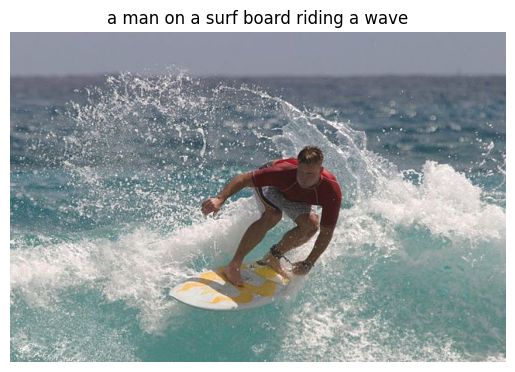

In [ ]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


LOAD_MODEL_BASE_DIR = os.path.join(os.path.abspath(
    '.'), 'trained_caption_model_keras_tes')

tokenizer_load_path = os.path.join(LOAD_MODEL_BASE_DIR, 'tokenizer.pkl')
projector_keras_load_path = os.path.join(
    LOAD_MODEL_BASE_DIR, 'vit_feature_projector.keras')
decoder_keras_load_path = os.path.join(
    LOAD_MODEL_BASE_DIR, 'caption_transformer_decoder.keras')
config_load_path = os.path.join(LOAD_MODEL_BASE_DIR, 'model_config.json')

print("Memuat konfigurasi...")
with open(config_load_path, 'r') as f:
    loaded_config = json.load(f)
print(f"Konfigurasi dimuat.")  

print("Memuat tokenizer...")
with open(tokenizer_load_path, 'rb') as f:
    loaded_tokenizer_object = pickle.load(f)
print("Tokenizer dimuat.")


global tokenizer
tokenizer = loaded_tokenizer_object

custom_objects = {
    'MultiHeadAttentionTF': MultiHeadAttentionTF,
    'DecoderLayer': DecoderLayer,
    'TransformerCaptionDecoder': TransformerCaptionDecoder,
    'ViTFeaturesProjection': ViTFeaturesProjection

}


print(f"Memuat ViT base model: {loaded_config['VIT_MODEL_NAME']}...")
try:
    hf_vit_image_processor = ViTImageProcessor.from_pretrained(
        loaded_config["VIT_MODEL_NAME"])
    hf_vit_model = TFViTModel.from_pretrained(loaded_config["VIT_MODEL_NAME"])
    hf_vit_model.trainable = False
    print("ViT base model dari Hugging Face berhasil dimuat.")
except Exception as e:
    print(f"Gagal memuat ViT base model dari Hugging Face: {e}")
    hf_vit_image_processor, hf_vit_model = None, None

print(f"Memuat ViT Feature Projector dari: {projector_keras_load_path}...")
try:
    loaded_projector = tf.keras.models.load_model(
        projector_keras_load_path, custom_objects=custom_objects)
    print("ViT Feature Projector (.keras) berhasil dimuat.")

except Exception as e:
    print(f"Gagal memuat ViT Feature Projector (.keras): {e}")
    loaded_projector = None

print(f"Memuat Transformer Caption Decoder dari: {decoder_keras_load_path}...")
try:
    loaded_decoder = tf.keras.models.load_model(
        decoder_keras_load_path, custom_objects=custom_objects)
    print("Transformer Caption Decoder (.keras) berhasil dimuat.")

    if loaded_decoder is not None and not loaded_decoder.built:
        print("Membangun loaded_decoder secara eksplisit setelah memuat...")
        dummy_batch_size_load = 1
        dummy_caption_len_load = loaded_config['max_caption_length'] - \
            1 if loaded_config['max_caption_length'] > 1 else 1
        dummy_num_patches_load = loaded_config['NUM_PATCHES']
        dummy_d_model_load = loaded_config['D_MODEL_TRANSFORMER']

        dummy_tar_input_load = tf.zeros(
            (dummy_batch_size_load, dummy_caption_len_load), dtype=tf.int32)
        dummy_projected_features_load = tf.zeros(
            (dummy_batch_size_load, dummy_num_patches_load, dummy_d_model_load), dtype=tf.float32)

        _ = loaded_decoder(dummy_tar_input_load,
                           dummy_projected_features_load, training=False)
        print("loaded_decoder berhasil dibangun setelah pemuatan.")

except Exception as e:
    print(f"Gagal memuat Transformer Caption Decoder (.keras): {e}")
    import traceback
    traceback.print_exc()
    loaded_decoder = None


def load_and_preprocess_image_for_vit_eval(image_path_str, processor):
    try:
        img = Image.open(image_path_str).convert("RGB")
        processed_inputs = processor(images=img, return_tensors="tf")
        img_tensor = processed_inputs['pixel_values']
        return img_tensor, image_path_str
    except Exception as e:
        print(f"Error loading/processing image {image_path_str}: {e}")
        return None, image_path_str


def evaluate_caption_with_keras_models(image_path_str_eval):
    if not all([hf_vit_image_processor, hf_vit_model, loaded_projector, loaded_decoder, tokenizer]):  # Periksa tokenizer global
        print("Satu atau lebih komponen model atau tokenizer gagal dimuat/di-set. Evaluasi dibatalkan.")
        return ["<error model/tokenizer load>"], np.array([])

    max_gen_len = loaded_config['max_caption_length']
    img_tensor_eval, _ = load_and_preprocess_image_for_vit_eval(
        image_path_str_eval, hf_vit_image_processor)
    if img_tensor_eval is None:
        return ["<error image load>"], np.array([])

    vit_output_eval = hf_vit_model(
        img_tensor_eval, training=False) 
    raw_vit_patches_eval = vit_output_eval.last_hidden_state[:, 1:, :]

    projected_vit_features_eval = loaded_projector(
        raw_vit_patches_eval, training=False)


    start_token_id = loaded_config['start_token_id']
    end_token_id = loaded_config['end_token_id']
 
    decoder_output_sequence = tf.expand_dims([start_token_id], 0)
    generated_caption_words = []

    for i in range(max_gen_len):
        predictions_step, attention_step = caption_transformer_decoder(

            decoder_output_sequence, projected_vit_features_eval, training=False
        )
        last_token_predictions = predictions_step[:, -1:, :]
        predicted_id_step = tf.cast(
            tf.argmax(last_token_predictions, axis=-1), tf.int32)

        if predicted_id_step[0][0] == end_token_id:
            break

        decoder_output_sequence = tf.concat(
            [decoder_output_sequence, predicted_id_step], axis=-1)

        generated_caption_words.append(tokenizer.index_word.get(
            predicted_id_step.numpy()[0][0], "<unk>"))

    return generated_caption_words, np.array([])


def display_image_and_caption(image_path, caption_words):
    try:
        img = Image.open(image_path)
        plt.imshow(img)
        plt.title(' '.join(caption_words))
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error displaying image {image_path}: {e}")


if loaded_projector and loaded_decoder and hf_vit_model and tokenizer:
    print("\n--- Evaluasi dengan Model .keras yang Dimuat ---")
    custom_img_url = 'https://tensorflow.org/images/surf.jpg'
    custom_img_filename = "surf_eval_keras.jpg"
    try:
        custom_eval_image_path = tf.keras.utils.get_file(
            custom_img_filename, origin=custom_img_url, cache_subdir=os.path.abspath('.'))
        print(f"Gambar evaluasi: {custom_eval_image_path}")

        predicted_words, _ = evaluate_caption_with_keras_models(
            custom_eval_image_path)

        print(
            f"Predicted Caption (Loaded .keras Model): {' '.join(predicted_words)}")
        display_image_and_caption(custom_eval_image_path, predicted_words)
    except Exception as e:
        print(f"Error saat evaluasi gambar kustom: {e}")
        import traceback
        traceback.print_exc()
else:
    print("\nEvaluasi tidak dapat dijalankan karena satu atau lebih model/tokenizer gagal dimuat atau di-set.")


--- Evaluasi Gambar Kustom dengan Full Transformer ---
Gambar lokal ditemukan: /home/c14210092/vit/load.jpg
Prediction (Custom): a soccer ball in the park with a few different kinds of scissors


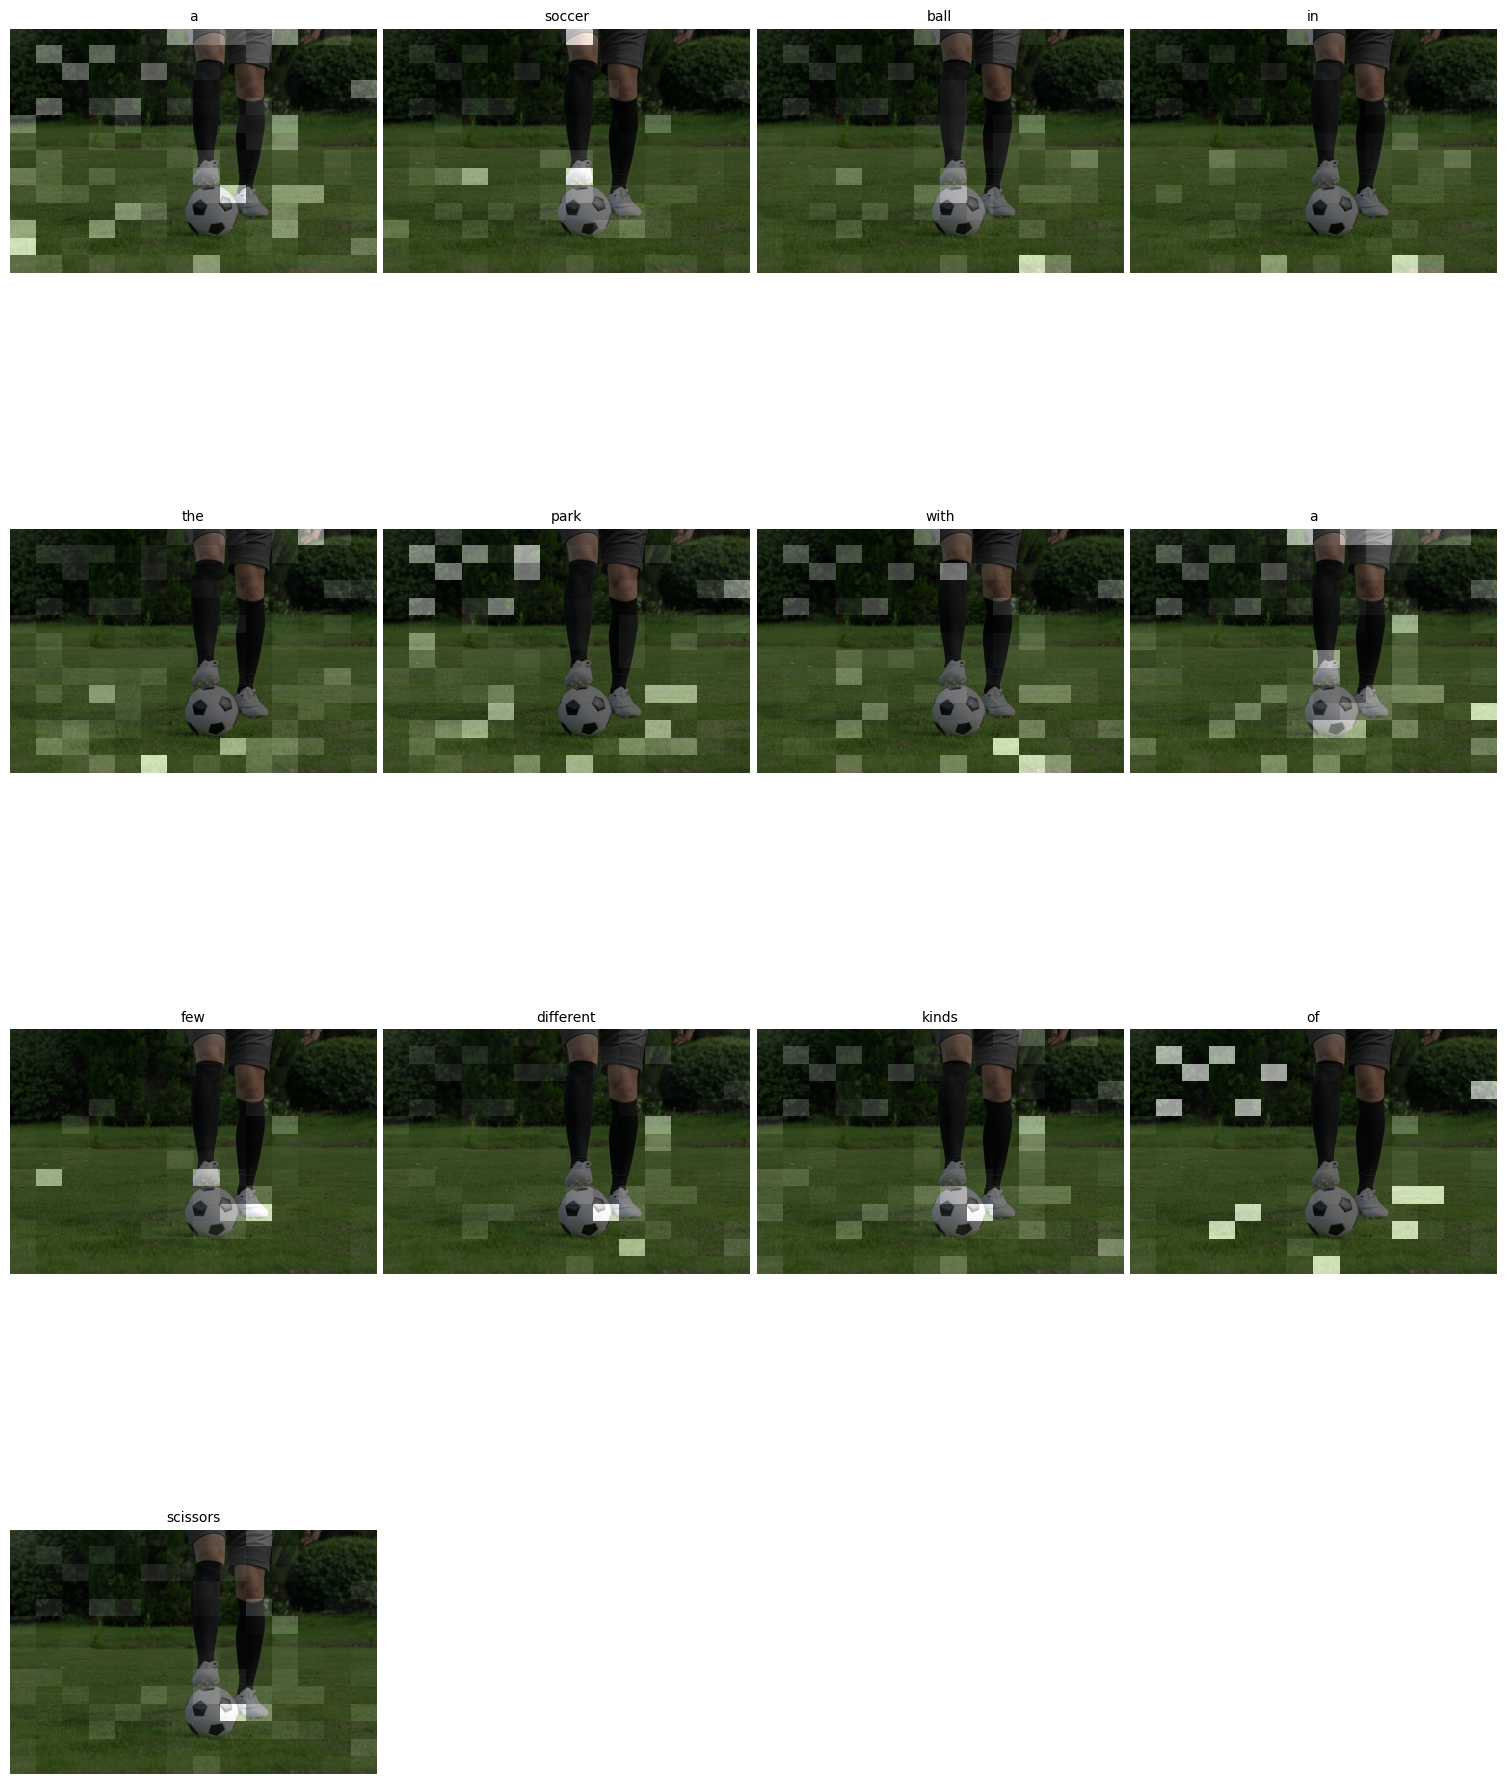

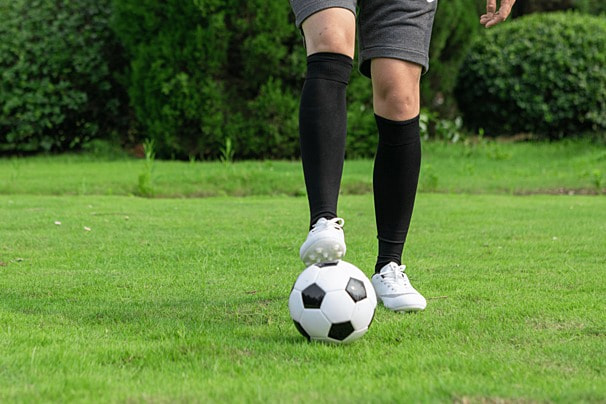

In [ ]:
print(f"\n--- Evaluasi Gambar Kustom dengan Full Transformer ---")
custom_img_local_path = os.path.abspath(
    'load.jpg')  

if os.path.exists(custom_img_local_path):
    print(f"Gambar lokal ditemukan: {custom_img_local_path}")
    custom_pred_words, custom_att_map = evaluate_caption_transformer(
        custom_img_local_path)
    print(f"Prediction (Custom): {' '.join(custom_pred_words)}")
    plot_attention_transformer_model(
        custom_img_local_path, custom_pred_words, custom_att_map)
    try:
        display(Image.open(custom_img_local_path))
    except NameError:
        Image.open(custom_img_local_path).show()
else:
    print(
        f"Gambar load.jpg tidak ditemukan di direktori ini: {custom_img_local_path}")